In [408]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import TransformerMixin
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# reading the data

train = pd.read_csv('products_sentiment_train.tsv', sep='\t', header=None, names=['text', 'target'])
test = pd.read_csv('products_sentiment_test.tsv', sep='\t', index_col='Id')

stop_words = nltk.corpus.stopwords.words('english')

In [351]:
train.head()

,text,target
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [352]:
train.describe()

,target
count,2000.000000
mean,0.637000
std,0.480985
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [353]:
test.head()

,text
Id,
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


In [354]:
test.describe()

,text
count,500
unique,500
top,though nearly a dozen different people at both...
freq,1


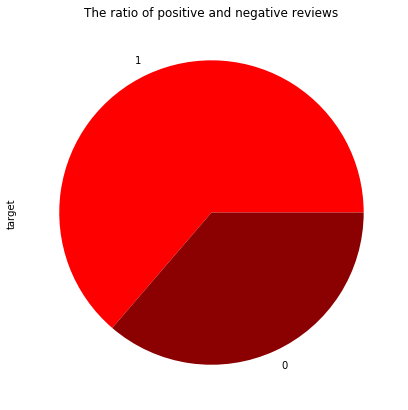

In [355]:
figure = plt.figure(figsize=(7, 7))
train['target'].value_counts().plot(kind='pie', colors = ['red', 'darkred'])

plt.title('The ratio of positive and negative reviews')
plt.show()

In [356]:
print('Positive:', (train['target'] == 1).sum())
print('Negative:', (train['target'] == 0).sum())

Positive: 1274
Negative: 726


In [407]:
# balancing classes
train_balanced = shuffle(train.append(train.iloc[list(train[train['target'] == 0].index[:500])]), random_state=10)

print('Positive:', (train_balanced['target'] == 1).sum())
print('Negative:', (train_balanced['target'] == 0).sum())

Positive: 1274
Negative: 1226


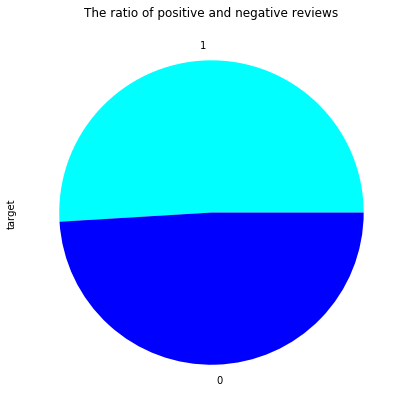

In [358]:
figure = plt.figure(figsize=(7, 7))
train_balanced['target'].value_counts().plot(kind='pie', colors = ['cyan', 'blue'])

plt.title('The ratio of positive and negative reviews')
plt.show()

In [359]:
train_balanced.head()

,text,target
648,"also , very light and portable .",1
331,knocked 1 star off for the install wizard - it...,0
1158,"the focus is great , though , if you are not t...",1
831,it would not hang up on calls .,0
1967,the hands-free speakerphone is quite powerful ...,1


In [360]:
train_balanced.shape

(2500, 2)

In [406]:
# tokenization

cvect = CountVectorizer()
token_matrix = cvect.fit_transform(train_balanced['text'])

token_matrix.shape

(2500, 3973)

In [362]:
tfidf = TfidfTransformer()
frequency_counts = tfidf.fit_transform(token_matrix)

frequency_counts.shape

(2500, 3973)

In [363]:
X = train_balanced['text'].values
y = train_balanced['target'].values

X_test = test['text'].values

print(y[20:30])
print('')
print(X[20:30])

[0 0 0 1 1 1 0 1 1 0]

['the zen xtra will transfer the files to the player , but not the folder name . '
 'even with newborn diapers it filled way too fast .'
 'one little minor flaw with this camera is that the lens is visible in the viewfinder , but does not detract from the image at all . '
 'anywhere i went in south africa this phone received full bar reception . '
 'the songs recorded with fm are as good as the original signal .'
 "i did n't think i would find this quality and ease of use for under $ 1500 - i 'm thrilled with my purchase ! "
 'this product has virtually all the same installation problems .'
 'this program enables the user to batch convert and convert audio files from one format to another .'
 "- equipment included is average , but that is n't a big deal since thats not what you are buying it for . "
 'typically , the problem is the headphone jack -- it was for me and many others . ']


In [364]:
rs = 42 # random_state
cv = 5


def estimator(classifier, parameters_grid, scorer, data, labels):
    pipeline = text_classifier(CountVectorizer(), TfidfTransformer(), classifier)
    
    grid_cv = RandomizedSearchCV(pipeline, parameters_grid, scoring = scorer, cv=cv, random_state=rs, n_iter=100)
    grid_cv.fit(data, labels)
    
    return grid_cv


def classifier(vectorizer, transformer, classifier):
    return Pipeline(
            [('vectorizer', vectorizer),
            ('transformer', transformer),
            ('classifier', classifier)]
        )


grid_vectorizer = {
    'vectorizer__max_df' : [0.85, 0.9, 0.95, 1.0],
    'vectorizer__min_df' : [1, 10, 20], 
    'vectorizer__ngram_range' : [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6)],
    'vectorizer__stop_words' : [stop_words, None, 'english']
}

## Finding the best model

#### Linear classifiers

In [365]:
for name, clf in {'LogisticRegression': LogisticRegression,
               'LinearSVC': LinearSVC, 
               'SGDClassifier': SGDClassifier,
               'RidgeClassifier': RidgeClassifier}.items():

    print(name, ': ', round(cross_val_score(classifier(CountVectorizer(), 
                                                   TfidfTransformer(), 
                                                   clf(random_state=rs)), 
                                   
                                   X, y, scoring='accuracy').mean(), 3), sep='')

LogisticRegression: 0.808
LinearSVC: 0.843
SGDClassifier: 0.832
RidgeClassifier: 0.843


In [366]:
# parameter grids

grid_lr = {
    'classifier__C': [0.8, 1, 1.2, 1.4],
    'classifier__max_iter': [50, 70, 90, 110],
    'classifier__solver': ['lbfgs', 'liblinear', 'sag']
}

grid_lsvc = {
    'classifier__loss': ['hinge', 'squared_hinge'], 
    'classifier__max_iter': [300, 500, 700, 900, 1100],
    'classifier__tol': [1e-5, 1e-4, 1e-3],
    'classifier__C': [1.0, 1.1, 1.2, 1.5]
}

grid_sgdc = {
    'classifier__loss': ['log', 'hinge', 'modified_huber'], 
    'classifier__penalty':  ['l1', 'l2', 'elasticnet'], 
    'classifier__max_iter': np.arange(100, 1000, 50),
    'classifier__tol': np.arange(1e-5, 1e-3, 1e-5)
}

grid_rc = {
    'classifier__alpha': [0.5, 0.7, 1, 1.5, 3, 5],
    'classifier__normalize': [True, False], 
    'classifier__tol': [0.0001, 0.0005, 0.001, 0.0015, 0.002],
    'classifier__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag']
}

#### Decision tree classifiers

In [405]:
for name, clf in {'DecisionTreeClassifier': DecisionTreeClassifier,
               'RandomForestClassifier': RandomForestClassifier,
               'BaggingClassifier': BaggingClassifier,
               'GradientBoostingClassifier': GradientBoostingClassifier}.items():

    print(name, ': ', round(cross_val_score(classifier(CountVectorizer(), 
                                                   TfidfTransformer(), 
                                                   clf(random_state=rs)), 
                                   
                                   X, y, scoring='accuracy').mean(), 3), sep='')

DecisionTreeClassifier: 0.777
RandomForestClassifier: 0.849
BaggingClassifier: 0.792
GradientBoostingClassifier: 0.755


In [368]:
# parameter grids

grid_dtc = {
    'classifier__max_depth': np.arange(1, 30, 5),
    'classifier__min_samples_split': np.arange(2, 5, 1),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5)
}

grid_rfc = {
    'classifier__n_estimators': np.arange(1, 30, 5),
    'classifier__max_depth': [None] + list(np.arange(1, 30, 5)),
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__min_samples_leaf': [1, 2, 3],
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__min_impurity_decrease': np.logspace(-10, -6, 5)
}

grid_bc = {
    'classifier__n_estimators': np.arange(10, 1000, 10),
    'classifier__warm_start': [False, True], 
    'classifier__bootstrap_features': [False, True]
}

grid_gbc = {
    'classifier__n_estimators': np.arange(10, 1000, 20),
    'classifier__max_depth': [None] + list(np.arange(1, 30, 1)),
    'classifier__min_samples_split': np.arange(2, 6, 1),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__subsample': np.arange(0.5, 1, 0.1)
}

#### Naive Bayes classifiers

In [369]:
for name, clf in {'MultinomialNB': MultinomialNB,
                  'BernoulliNB': BernoulliNB,
                  'GaussianNB': GaussianNB}.items():
    
    if name == 'GaussianNB':
        print(name, ': ', round(cross_val_score(Pipeline([('vectorizer', CountVectorizer()), 
                                                          ('transformer', TfidfTransformer()),
                                  ('dense', DenseTransformer()), ('classifier', GaussianNB())]), 
                                             X, y, scoring='accuracy').mean(), 3), sep='')
    else:
        print(name, ': ', round(cross_val_score(classifier(CountVectorizer(), 
                                                             TfidfTransformer(), 
                                                             clf()), 
                                             X, y, scoring='accuracy').mean(), 3), sep='')

MultinomialNB: 0.828
BernoulliNB: 0.821
GaussianNB: 0.705


In [370]:
# parameter grids

grid_mnb = {
    'classifier__alpha': np.logspace(0, 5, 100), 
    'classifier__fit_prior': [True, False]
}

grid_bnb = {
    'classifier__alpha': np.logspace(0, 5, 100),
    'classifier__fit_prior': [True, False]
}

### Grid search

In [381]:
%%time
grid_search_lr = estimator(LogisticRegression(random_state=rs), grid_lr, 'accuracy', X, y)

print('')
print('LogisticRegression')
print('Best score:', round(grid_search_lr.best_score_, 4))
print('')
print('Parameters:', grid_search_lr.best_params_)


LogisticRegression
Best score: 0.8164

Parameters: {'classifier__solver': 'lbfgs', 'classifier__max_iter': 50, 'classifier__C': 1.4}
CPU times: user 21.1 s, sys: 76 ms, total: 21.2 s
Wall time: 21.2 s


In [382]:
%%time
grid_search_lsvc = estimator(LinearSVC(random_state=rs), grid_lsvc, 'accuracy', X, y)

print('')
print('LinearSVC')
print('Best score:', round(grid_search_lsvc.best_score_, 4))
print('')
print('Parameters:', grid_search_lsvc.best_params_)


LinearSVC
Best score: 0.8432

Parameters: {'classifier__tol': 0.001, 'classifier__max_iter': 900, 'classifier__loss': 'squared_hinge', 'classifier__C': 1.0}
CPU times: user 40.3 s, sys: 59.9 ms, total: 40.4 s
Wall time: 40.4 s


In [383]:
%%time
grid_search_sgdc = estimator(SGDClassifier(random_state=rs), grid_sgdc, 'accuracy', X, y)

print('')
print('SGDClassifier')
print('Best score:', round(grid_search_sgdc.best_score_, 4))
print('')
print('Parameters:', grid_search_sgdc.best_params_)


SGDClassifier
Best score: 0.8416

Parameters: {'classifier__tol': 0.00019, 'classifier__penalty': 'l2', 'classifier__max_iter': 400, 'classifier__loss': 'log'}
CPU times: user 40.9 s, sys: 48 ms, total: 41 s
Wall time: 41 s


In [384]:
%%time
grid_search_rc = estimator(RidgeClassifier(random_state=rs), grid_rc, 'accuracy', X, y)

print('')
print('RidgeClassifier')
print('Best score:', round(grid_search_rc.best_score_, 4))
print('')
print('Parameters:', grid_search_rc.best_params_)


RidgeClassifier
Best score: 0.8428

Parameters: {'classifier__tol': 0.001, 'classifier__solver': 'auto', 'classifier__normalize': False, 'classifier__alpha': 1}
CPU times: user 32.5 s, sys: 19.9 ms, total: 32.5 s
Wall time: 32.5 s


In [385]:
%%time
grid_search_dtc = estimator(DecisionTreeClassifier(random_state=rs), grid_dtc, 'accuracy', X, y)

print('')
print('DecisionTreeClassifier')
print('Best score:', round(grid_search_dtc.best_score_, 4))
print('')
print('Parameters:', grid_search_dtc.best_params_)


DecisionTreeClassifier
Best score: 0.73

Parameters: {'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_impurity_decrease': 1e-10, 'classifier__max_depth': 26}
CPU times: user 1min, sys: 47.9 ms, total: 1min
Wall time: 1min


In [386]:
%%time
grid_search_rfc = estimator(RandomForestClassifier(random_state=rs), grid_rfc, 'accuracy', X, y)

print('')
print('RandomForestClassifier')
print('Best score:', round(grid_search_rfc.best_score_, 4))
print('')
print('Parameters:', grid_search_rfc.best_params_)


RandomForestClassifier
Best score: 0.8524

Parameters: {'classifier__n_estimators': 26, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 1, 'classifier__min_impurity_decrease': 1e-06, 'classifier__max_features': 'log2', 'classifier__max_depth': None}
CPU times: user 53.1 s, sys: 79.9 ms, total: 53.2 s
Wall time: 53.6 s


In [392]:
%%time
grid_search_bc = estimator(BaggingClassifier(random_state=rs), grid_bc, 'accuracy', X, y)

print('')
print('BaggingClassifier')
print('Best score:', round(grid_search_bc.best_score_, 4))
print('')
print('Parameters:', grid_search_bc.best_params_)


BaggingClassifier

CPU times: user 400 µs, sys: 1 µs, total: 401 µs
Wall time: 315 µs


In [341]:
%%time
grid_search_gbc = estimator(GradientBoostingClassifier(random_state=rs), grid_gbc, 'accuracy', X, y)

print('')
print('GradientBoostingClassifier')
print('Best score:', round(grid_search_gbc.best_score_, 4))
print('')
print('Parameters:', grid_search_gbc.best_params_)


GradientBoostingClassifier

CPU times: user 778 µs, sys: 2 µs, total: 780 µs
Wall time: 657 µs


In [388]:
%%time
grid_search_mnb = estimator(MultinomialNB(), grid_mnb, 'accuracy', X, y)

print('')
print('MultinomialNB')
print('Best score:', round(grid_search_mnb.best_score_, 4))
print('')
print('Parameters:', grid_search_mnb.best_params_)


MultinomialNB
Best score: 0.8256

Parameters: {'classifier__fit_prior': True, 'classifier__alpha': 1.1233240329780274}
CPU times: user 37.1 s, sys: 95.9 ms, total: 37.2 s
Wall time: 37.5 s


In [389]:
%%time
grid_search_bnb = estimator(BernoulliNB(), grid_bnb, 'accuracy', X, y)

print('')
print('BernoulliNB')
print('Best score:', round(grid_search_bnb.best_score_, 4))
print('')
print('Parameters:', grid_search_bnb.best_params_)


BernoulliNB
Best score: 0.818

Parameters: {'classifier__fit_prior': True, 'classifier__alpha': 1.1233240329780274}
CPU times: user 34.3 s, sys: 48 ms, total: 34.3 s
Wall time: 34.6 s


⠀  

  
Best linear model - **LinearSVC**    
Best Bayesian model - **MultinomialNB**    
Best decision tree model - **GradientBoostingClassifier**    

In [ ]:
''' {'classifier__tol': 0.001, 
     'classifier__max_iter': 900, 
     'classifier__loss': 'squared_hinge', 
     'classifier__C': 1.0} 

     {'classifier__fit_prior': True, 
      'classifier__alpha': 1.1233240329780274}
      
     {'vectorizer__stop_words': None, 
      'vectorizer__ngram_range': (1, 1), 
      'vectorizer__min_df': 1,
      'vectorizer__max_df': 0.85, 
      'classifier__subsample': 0.8999999999999999, 
      'classifier__n_estimators': 510, 
      'classifier__min_samples_split': 4, 
      'classifier__max_features': 'sqrt', 
      'classifier__max_depth': 14}
'''

## Predictions

In [393]:
# Linear SVC
lsvc = make_pipeline(CountVectorizer(min_df=1, ngram_range=(1, 5), max_df=0.9, stop_words=None),
                    TfidfTransformer(),
                    LinearSVC(max_iter=400, 
                              loss='squared_hinge', 
                              C=1.0, 
                              tol=0.001, 
                              random_state=rs))
lsvc.fit(X, y)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 5), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidftransformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scal

In [397]:
# MultinomialNB
mnb = make_pipeline(CountVectorizer(min_df=1, ngram_range=(1, 5), max_df=1, stop_words=None),
                    TfidfTransformer(),
                    MultinomialNB(alpha=1.1233240329780274, 
                    fit_prior=True))
mnb.fit(X, y)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 5), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidftransformer',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('multinomialnb',
                 MultinomialNB(alpha=1.1233240329780274, class_prior=None,
                               fit_prior=True))]

In [398]:
# GradientBoostingClassifier
gbc = make_pipeline(CountVectorizer(min_df=1, ngram_range=(1, 1), max_df=0.85, stop_words=None),
                    TfidfTransformer(),
                    GradientBoostingClassifier(subsample=0.9, 
                                               n_estimators=510, 
                                               min_samples_split=4, 
                                               max_features='sqrt', 
                                               max_depth=14))
gbc.fit(X, y)

Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.85,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vo...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=14, max_features='sqrt',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                         

In [399]:
lsvc_pred = lsvc.predict(X_test)
mnb_pred = mnb.predict(X_test)
gbc_pred = gbc.predict(X_test)

print(len(lsvc_pred), '|', len(mnb_pred), '|', len(gbc_pred))

500 | 500 | 500


In [404]:
with open('lsvc.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, lsvc_pred), sep=','), 
                                 columns=['ID,y']).to_csv(sep=' ', index=False))

with open('mnb.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, mnb_pred), sep=','), 
                                 columns=['ID,y']).to_csv(sep=' ', index=False))

with open('gbc.csv', 'w') as f:
    f.write(pd.DataFrame(pd.Series(map(str, range(0, 500))).str.cat(map(str, gbc_pred), sep=','), 
                                 columns=['ID,y']).to_csv(sep=' ', index=False))